In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Passata di preprocessing, alcuni valori hanno solo un dato di anomalous settato.

In [ ]:
df = pd.read_csv("dati_preprocessati.csv")

anomalous = 0
index = 0

for row in df.itertuples():
  # creo dataframe di appoggio con il giorno selezionato
  index = row[1]

  df_aux = df[df["Index"] == row[1]]

  for row_aux in df_aux.itertuples():
    if row_aux[3] == 1:
      anomalous = 1
    if anomalous == 1:
      df.loc[row[0],"Anomalous"] = 1

  anomalous = 0

print(df)
df.to_csv("preprocessato.csv")

      Index  Affluenza  Anomalous
0         1   1.000000          1
1         1   0.000000          1
2         1   0.299891          1
3         1   0.195044          1
4         1   0.198812          1
...     ...        ...        ...
4802    209   0.862443          1
4803    209   0.841555          1
4804    209   0.861950          1
4805    209   0.989119          1
4806    210   1.000000          1

[4807 rows x 3 columns]


Plottiamo le serie temporali di una porzione di dati con l'indicazione di anomalous. Questo plot mostra la diversità delle serie temporali anomale rispetto a quelle normali.

In [ ]:
df = pd.read_csv("preprocessato.csv")
del df["Unnamed: 0"]
print(df)

      Index  Affluenza  Anomalous
0         1   1.000000          1
1         1   0.000000          1
2         1   0.299891          1
3         1   0.195044          1
4         1   0.198812          1
...     ...        ...        ...
4802    209   0.862443          1
4803    209   0.841555          1
4804    209   0.861950          1
4805    209   0.989119          1
4806    210   1.000000          1

[4807 rows x 3 columns]


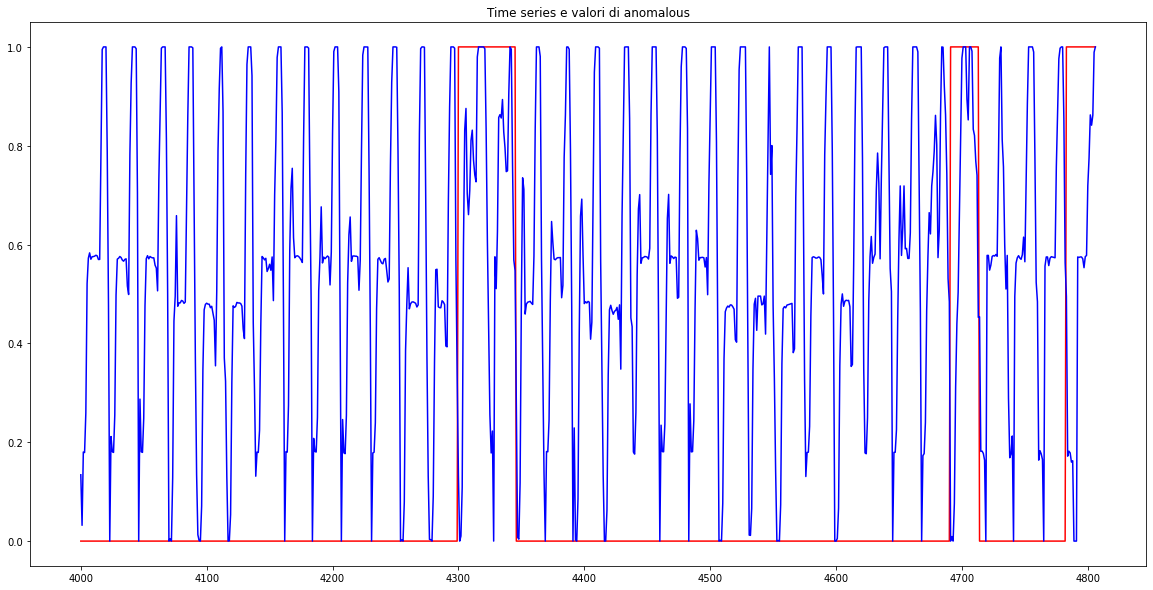

In [ ]:
df = df.iloc[4000:]
plt.figure(figsize=(20,10))

plt.title("Time series e valori di anomalous")
plt.plot(df.index,df["Anomalous"],color="r")

plt.plot(df.index,df["Affluenza"],color="b")
plt.show()

Massimo numero di giorno "normali" presenti nel dataset.

In [ ]:
df = pd.read_csv("preprocessato.csv")
del df["Unnamed: 0"]

cont = 0
cont_anomalous = 0
tot_days = 0 # debugging
saved = 0
finestra = []

for row in df.itertuples():
  
  if row[3] == 0:
    cont+=1
    finestra.append(0)
  else: 
    if cont > saved:
      saved = cont

    finestra.append(cont)
    cont_anomalous += 1
    tot_days += cont
    cont = 0

tot_days += cont_anomalous
print("Il numero massimo di giorni normali consecutivi è " + str(round(saved/23)) + " ( " + str(saved) + " righe )" + ", mentre i giorni anomali sono: " + str(round(cont_anomalous/23)) + ". I giorni totali sono " + str(round(tot_days/23)))

N = round(saved/23) - 1
df["Finestra"] = finestra
df.to_csv("finestra.csv")

Il numero massimo di giorni normali consecutivi è 59 ( 1357 righe ), mentre i giorni anomali sono: 12. I giorni totali sono 209


Plotto le time-series relative alle giornati normali. Negli spazi vuoti ci sono i giorni anomali.

No handles with labels found to put in legend.


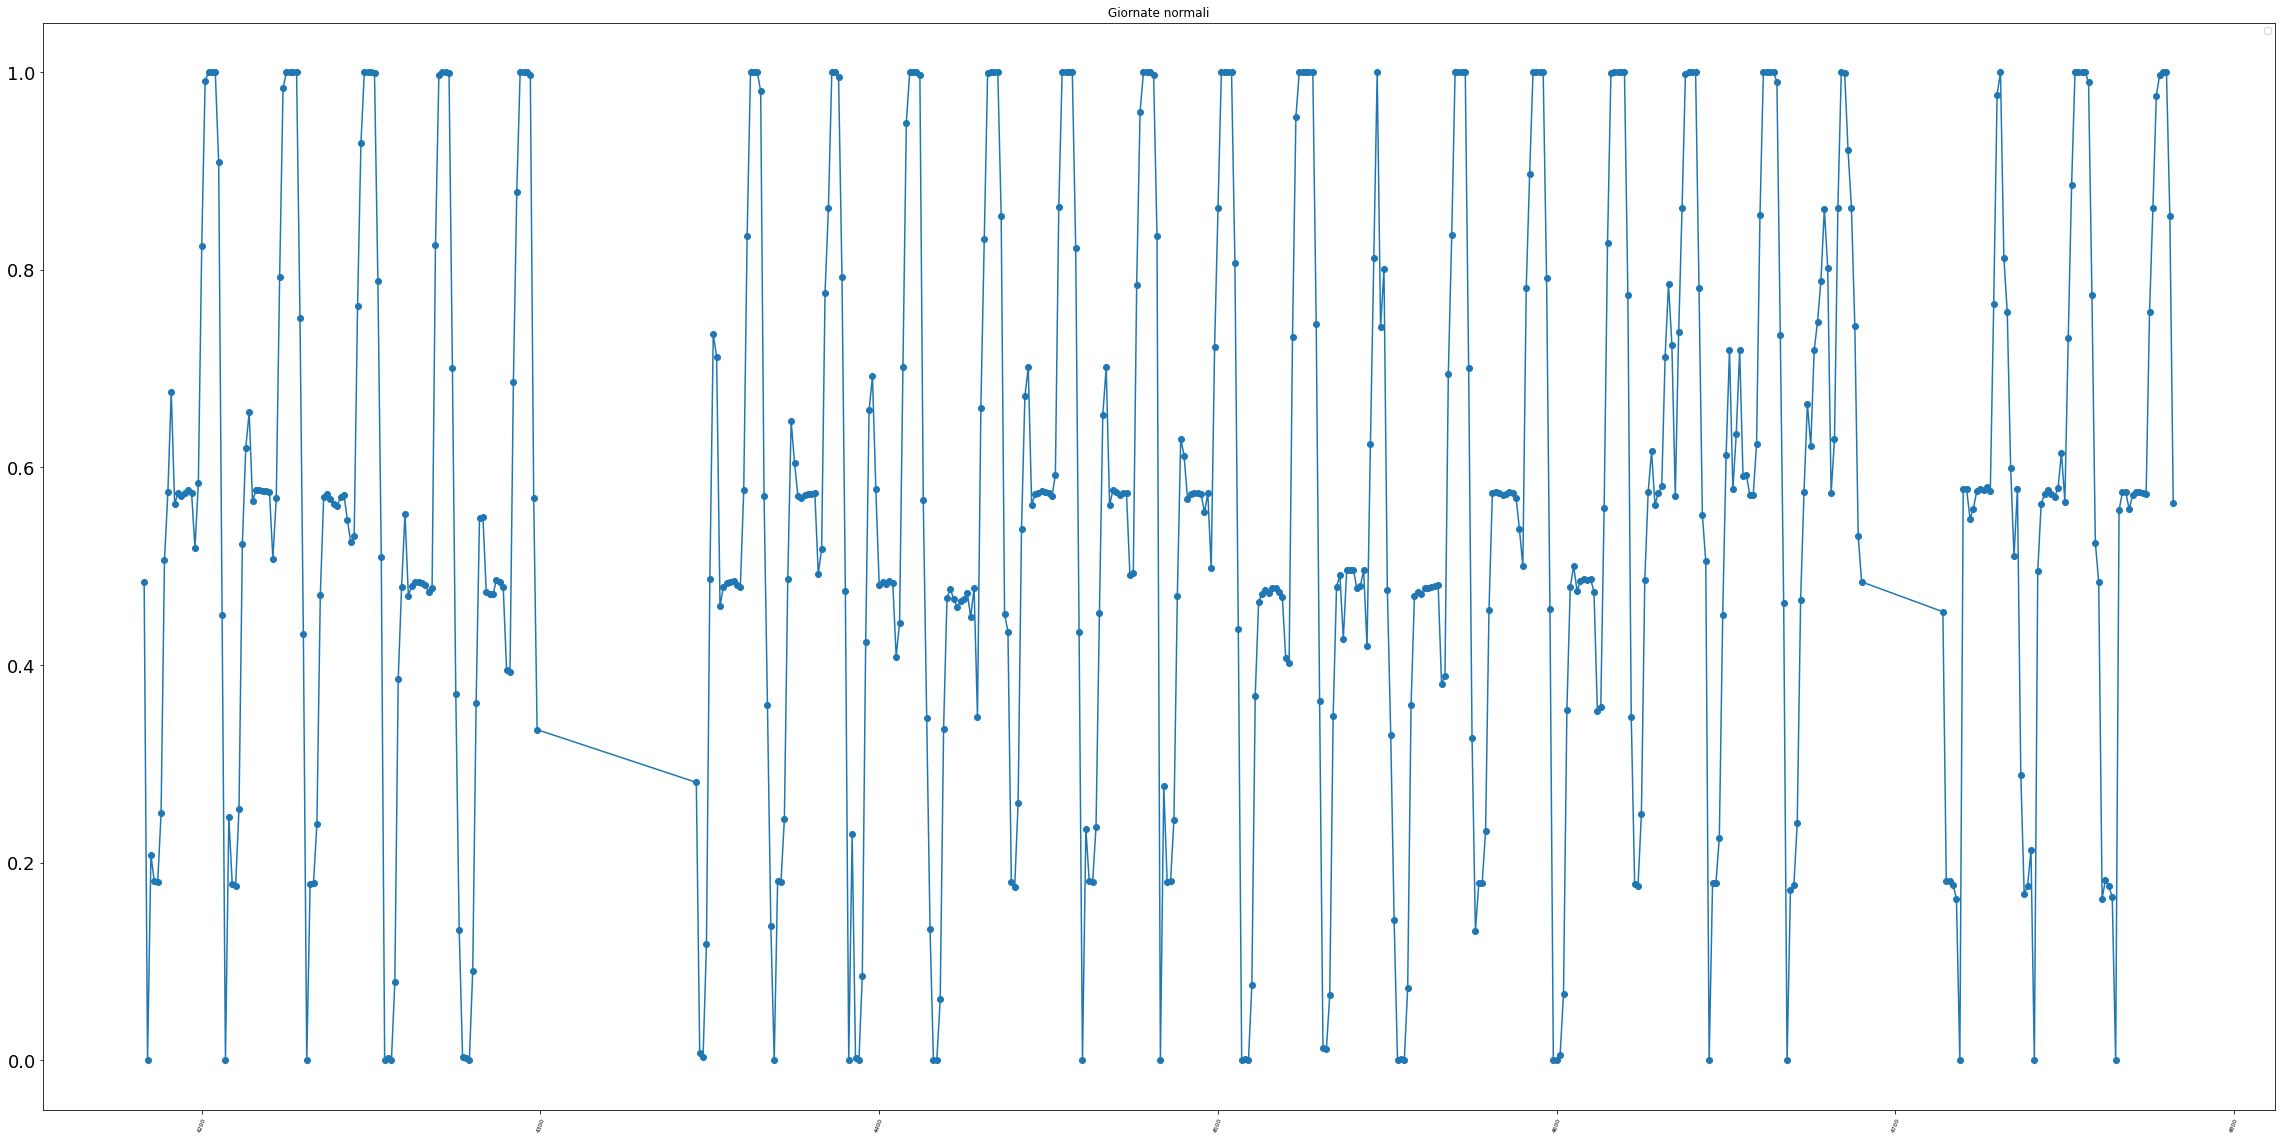

In [ ]:
# dataframe con gli N giorni normali precedenti ad un giorno anomalo
giorni_normali = df[df['Anomalous'] == 0 ]
giorni_normali.to_csv("normali.csv")

plt.figure(figsize=(40, 20))
plt.title("Giornate normali")
plt.plot(giorni_normali.iloc[4000:].index, giorni_normali['Affluenza'].iloc[4000:],marker="o")
plt.legend(loc='best', fontsize='small')
plt.xticks(fontsize=6)
plt.yticks(fontsize=18)
plt.xticks(rotation=70)
plt.show()

Plotto le time-series delle giornate anomale.

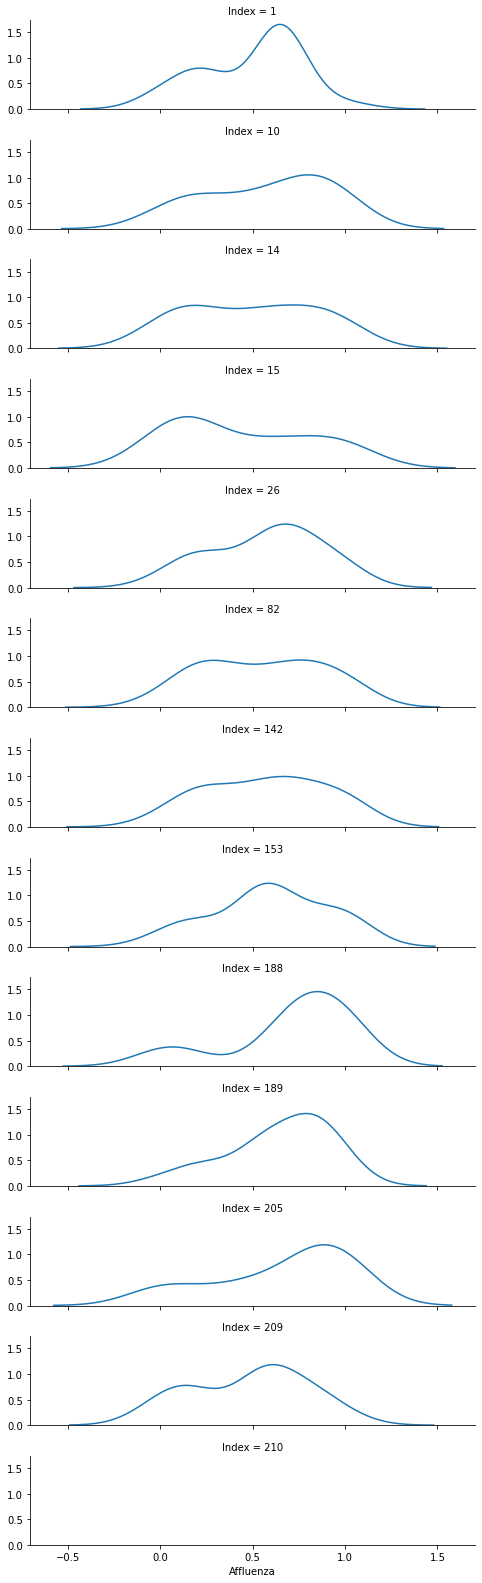

In [ ]:
giorni_anomali = df[df['Anomalous'] == 1 ]
giorni_anomali.to_csv("anomali.csv")

df = pd.read_csv("anomali.csv")

g = sns.FacetGrid(df, row="Index", height=1.7, aspect=4,)
g.map(sns.kdeplot, "Affluenza")

Definiamo delle funzioni che ci saranno utili in seguito:

In [ ]:
## Trova il dataframe target, ovvero la finestra di N giorni normali che precedono il giorno anomalo passato come parametro

def find_df_target(anomalo) :
  ret = []
  cont = 0
  max = anomalo
  
  # trovo tutti i giorni normali precedenti 
  x = giorni_normali[giorni_normali.index <= anomalo]

  x = pd.DataFrame(x)
  normal_day_before = x.shape[0]
  min = normal_day_before - (N-1)*23

  for row in giorni_normali.itertuples():
    if (row[5] > min) & (row[5] < max):
      ret.append(row)
      cont += 1

  print(ret)
  return ret

In [ ]:
## conteggio dei giorni normali che precedono il giorno anomalo passato per parametro

def find_count_normal_days(anomalo) :
    cont = 0
    quanti = []
    for x in giorni_normali.itertuples():
      if x[0] < anomalo:
        cont+=1
        quanti.append(cont)
      else:
        quanti.append(0)
    
    giorni_normali["Quanti"] = quanti
    return cont

In [ ]:
## funzione che effettua la predizione

def prediction(dataset,df,plot_df,row,cont) :
  n_input = 23
  n_features = 1

  # parametri: batch_size=32, epochs = 100
  generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
  model.add(Dropout(0.15))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(generator, epochs=90)

  pred_list = []
  batch = dataset[-n_input:].reshape((1, n_input, n_features))

  for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

  df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=df_target[-n_input:].index, columns=['Prediction'])

  df_anomali = pd.read_csv("anomali.csv")
  anomalia_visualizzata = df_anomali[df_anomali["Index"] == row[1]]
  anomalia_visualizzata.to_csv("giorno_anomalo_mostrato" + str(cont) + ".csv")
  
  plt.figure(figsize=(40, 20))

  plt.subplot(212)
  plt.plot(anomalia_visualizzata.index, anomalia_visualizzata["Affluenza"],marker="o",color = "b")
  plt.plot(anomalia_visualizzata.index, df_predict['Prediction'], color='r', marker="o")
  
  plt.subplot(221)

  plt.title("Confronto tra predizione e serie reale per giornata anomala")
  plt.plot(df_predict.index, df_predict["Prediction"], color='r', marker="o")
  plt.plot(df_target.iloc[-200:].index,df_target["Affluenza"].iloc[-200:],color = "b",marker="o")
  plt.legend(loc='best', fontsize='small')
  plt.xticks(fontsize=6)
  plt.yticks(fontsize=18)
  plt.xticks(rotation=70)
  
  plt.subplot(222)
  plt.plot(df_predict.index, df_predict['Prediction'], color='r', marker="o")

  plt.grid()
  plt.show()

In [ ]:
df = pd.read_csv("finestra.csv")
## calcolo la media dei giorni normali consecutivi
soglia = df[df["Finestra"] != 0]
soglia = soglia["Finestra"].mean()
print(round(soglia/23))

soglia = round(soglia/23)

22


Il valore medio di giorni normali consecutivi è 22, valore che impostiamo come soglia.

1748
437
      Index  Affluenza  Anomalous  Finestra  Quanti
22        2   0.231142          0         0       1
23        2   0.011124          0         0       2
24        2   0.010477          0         0       3
25        2   0.091583          0         0       4
26        2   0.412114          0         0       5
...     ...        ...        ...       ...     ...
4778    208   0.997464          0         0       0
4779    208   1.000000          0         0       0
4780    208   1.000000          0         0       0
4781    208   0.853960          0         0       0
4782    208   0.563657          0         0       0

[4531 rows x 5 columns]
[Pandas(Index=528, _1=24, Affluenza=0.01700737571609, Anomalous=0, Finestra=0, Quanti=438), Pandas(Index=529, _1=24, Affluenza=0.18117634572824, Anomalous=0, Finestra=0, Quanti=439), Pandas(Index=530, _1=24, Affluenza=0.180339385653725, Anomalous=0, Finestra=0, Quanti=440), Pandas(Index=531, _1=24, Affluenza=0.244400815461196, Anomalous=0, 

No handles with labels found to put in legend.


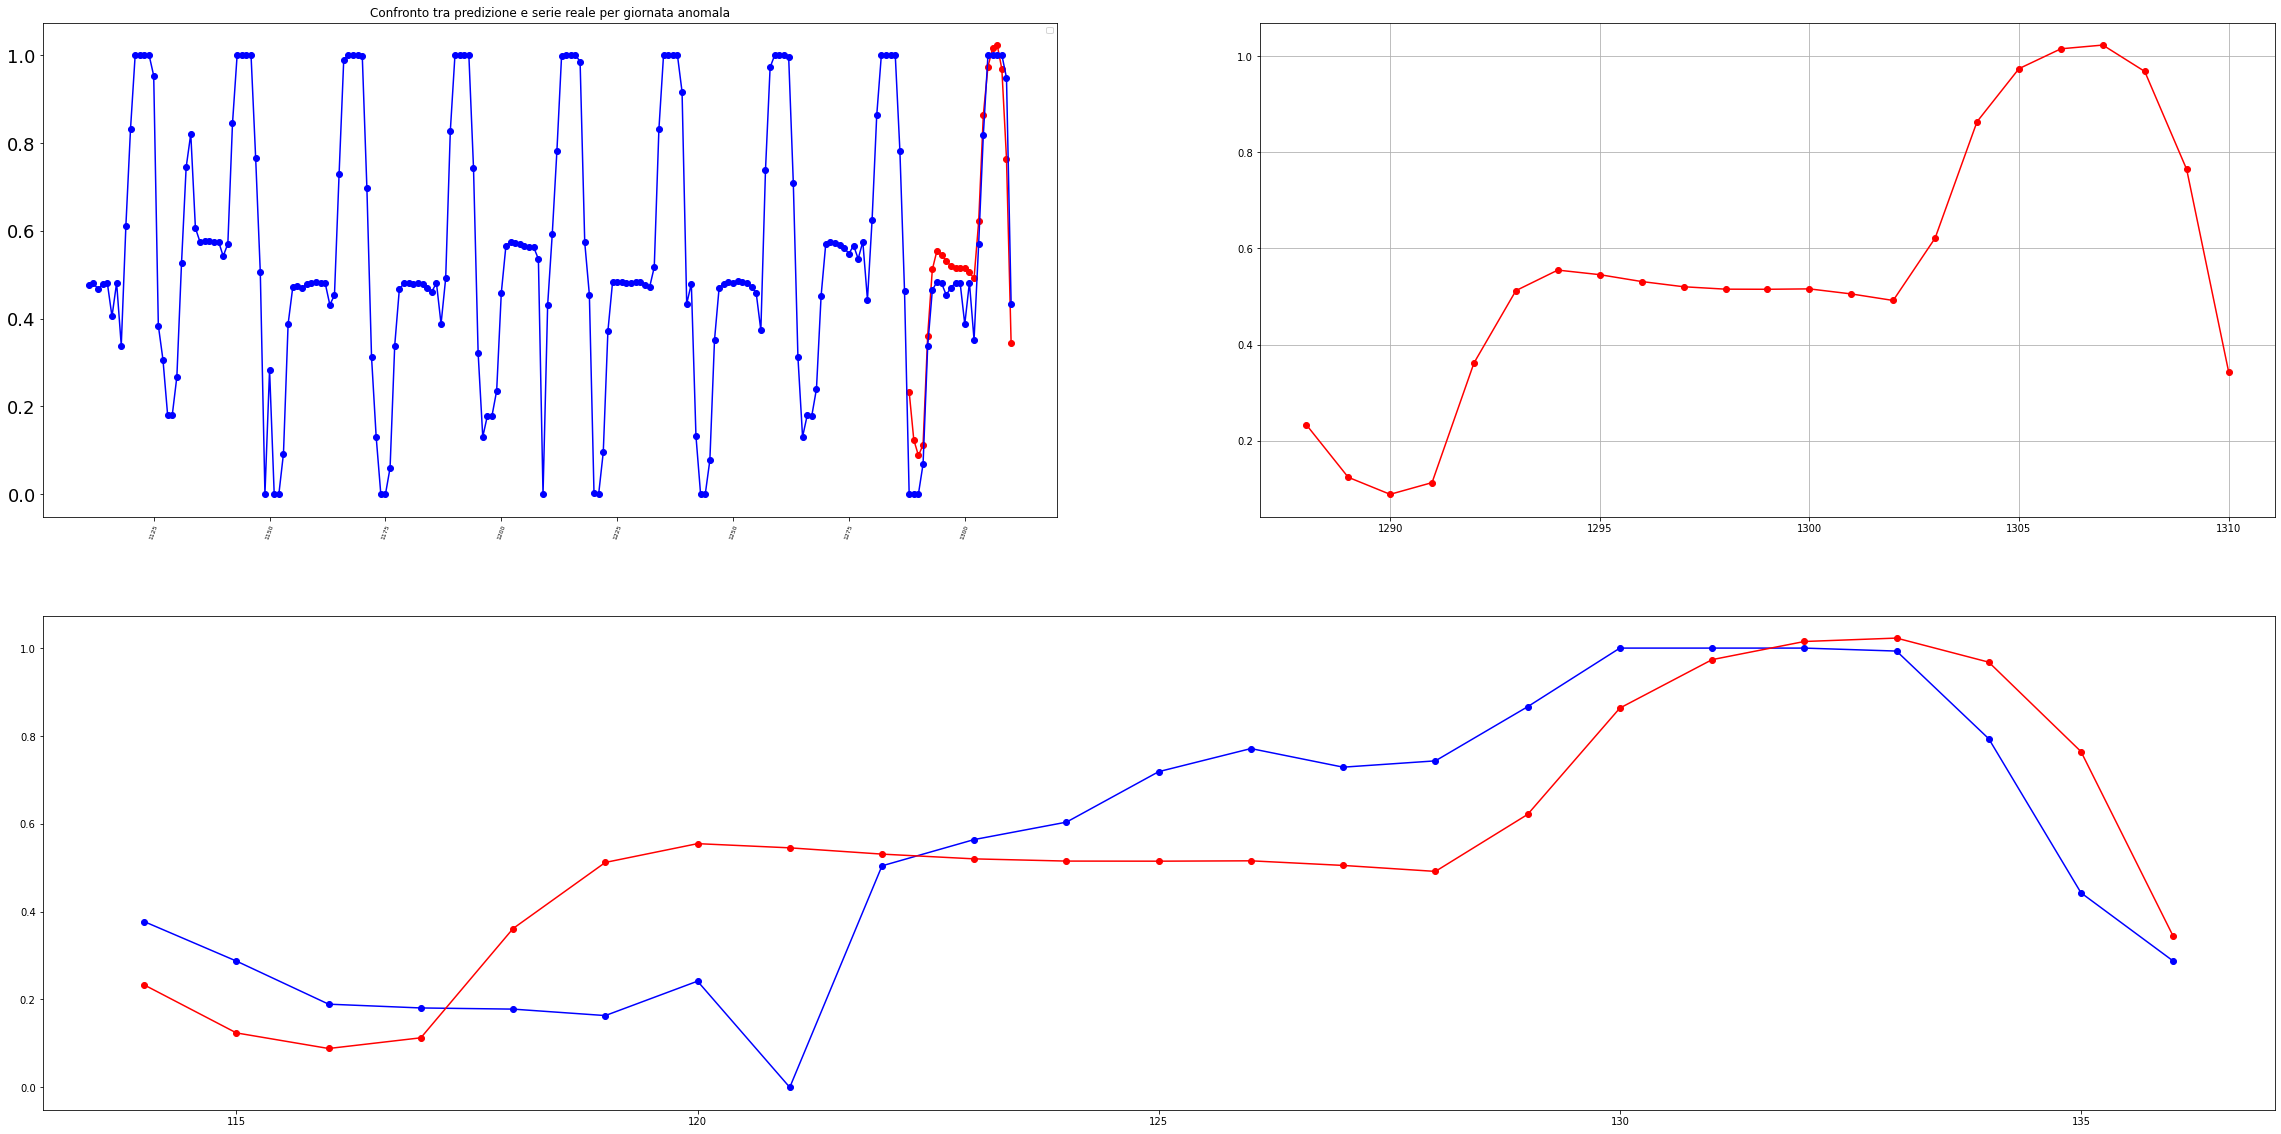

3105
1794
      Index  Affluenza  Anomalous  Finestra  Quanti
22        2   0.231142          0         0       1
23        2   0.011124          0         0       2
24        2   0.010477          0         0       3
25        2   0.091583          0         0       4
26        2   0.412114          0         0       5
...     ...        ...        ...       ...     ...
4778    208   0.997464          0         0       0
4779    208   1.000000          0         0       0
4780    208   1.000000          0         0       0
4781    208   0.853960          0         0       0
4782    208   0.563657          0         0       0

[4531 rows x 5 columns]
[Pandas(Index=1931, _1=85, Affluenza=0.215124679379552, Anomalous=0, Finestra=0, Quanti=1795), Pandas(Index=1932, _1=85, Affluenza=0.0, Anomalous=0, Finestra=0, Quanti=1796), Pandas(Index=1933, _1=85, Affluenza=0.00021951944596966002, Anomalous=0, Finestra=0, Quanti=1797), Pandas(Index=1934, _1=85, Affluenza=0.0833653097778477, Anomalous=0

No handles with labels found to put in legend.


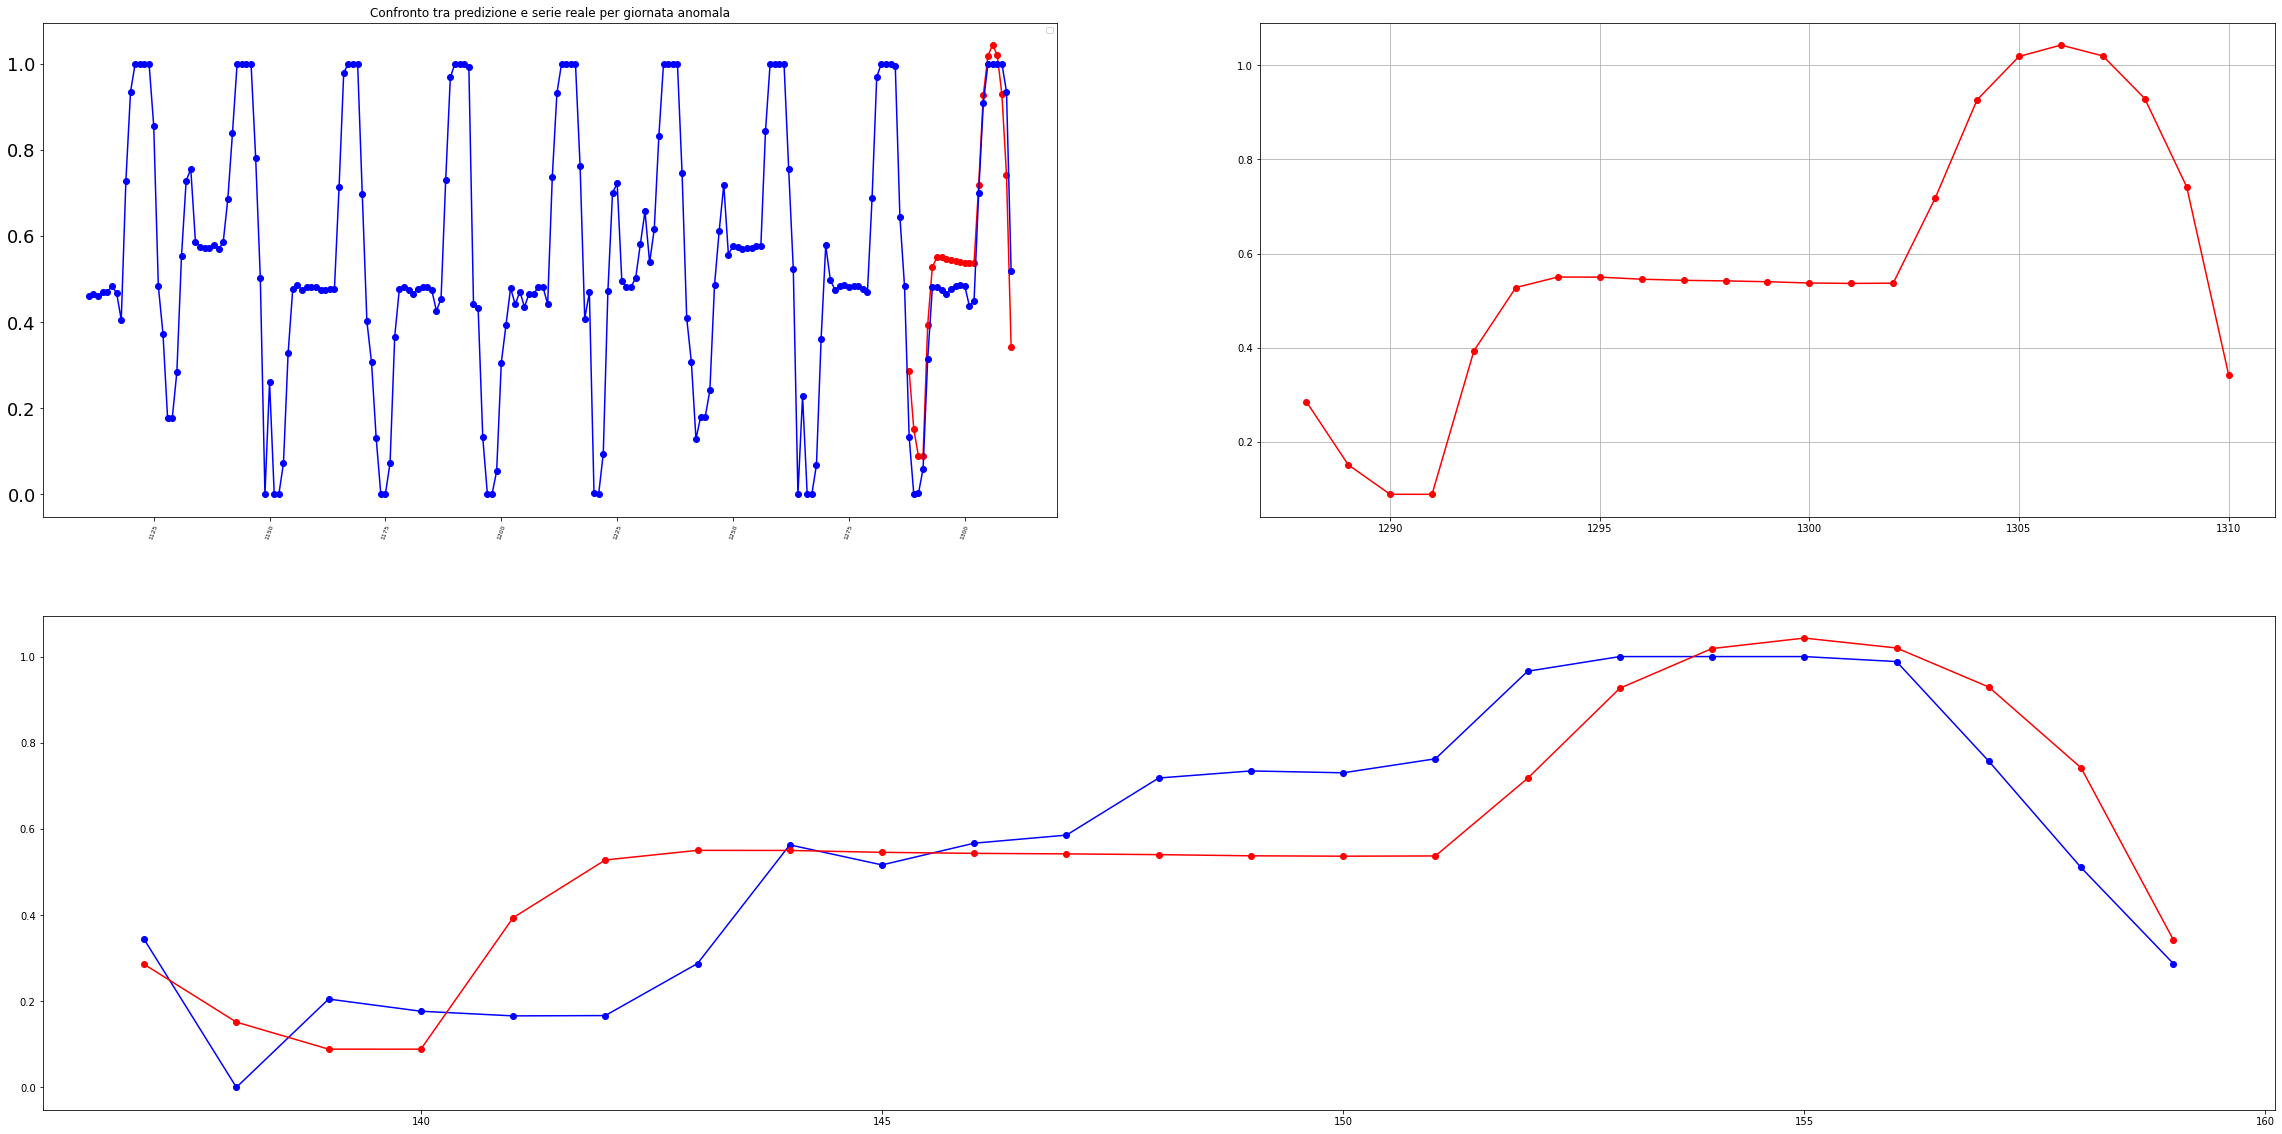

4117
2806
      Index  Affluenza  Anomalous  Finestra  Quanti
22        2   0.231142          0         0       1
23        2   0.011124          0         0       2
24        2   0.010477          0         0       3
25        2   0.091583          0         0       4
26        2   0.412114          0         0       5
...     ...        ...        ...       ...     ...
4778    208   0.997464          0         0       0
4779    208   1.000000          0         0       0
4780    208   1.000000          0         0       0
4781    208   0.853960          0         0       0
4782    208   0.563657          0         0       0

[4531 rows x 5 columns]
[Pandas(Index=2943, _1=129, Affluenza=0.13067641774400302, Anomalous=0, Finestra=0, Quanti=2807), Pandas(Index=2944, _1=129, Affluenza=0.0, Anomalous=0, Finestra=0, Quanti=2808), Pandas(Index=2945, _1=129, Affluenza=0.0035641709951408796, Anomalous=0, Finestra=0, Quanti=2809), Pandas(Index=2946, _1=129, Affluenza=0.0706945762219698, Anomal

No handles with labels found to put in legend.


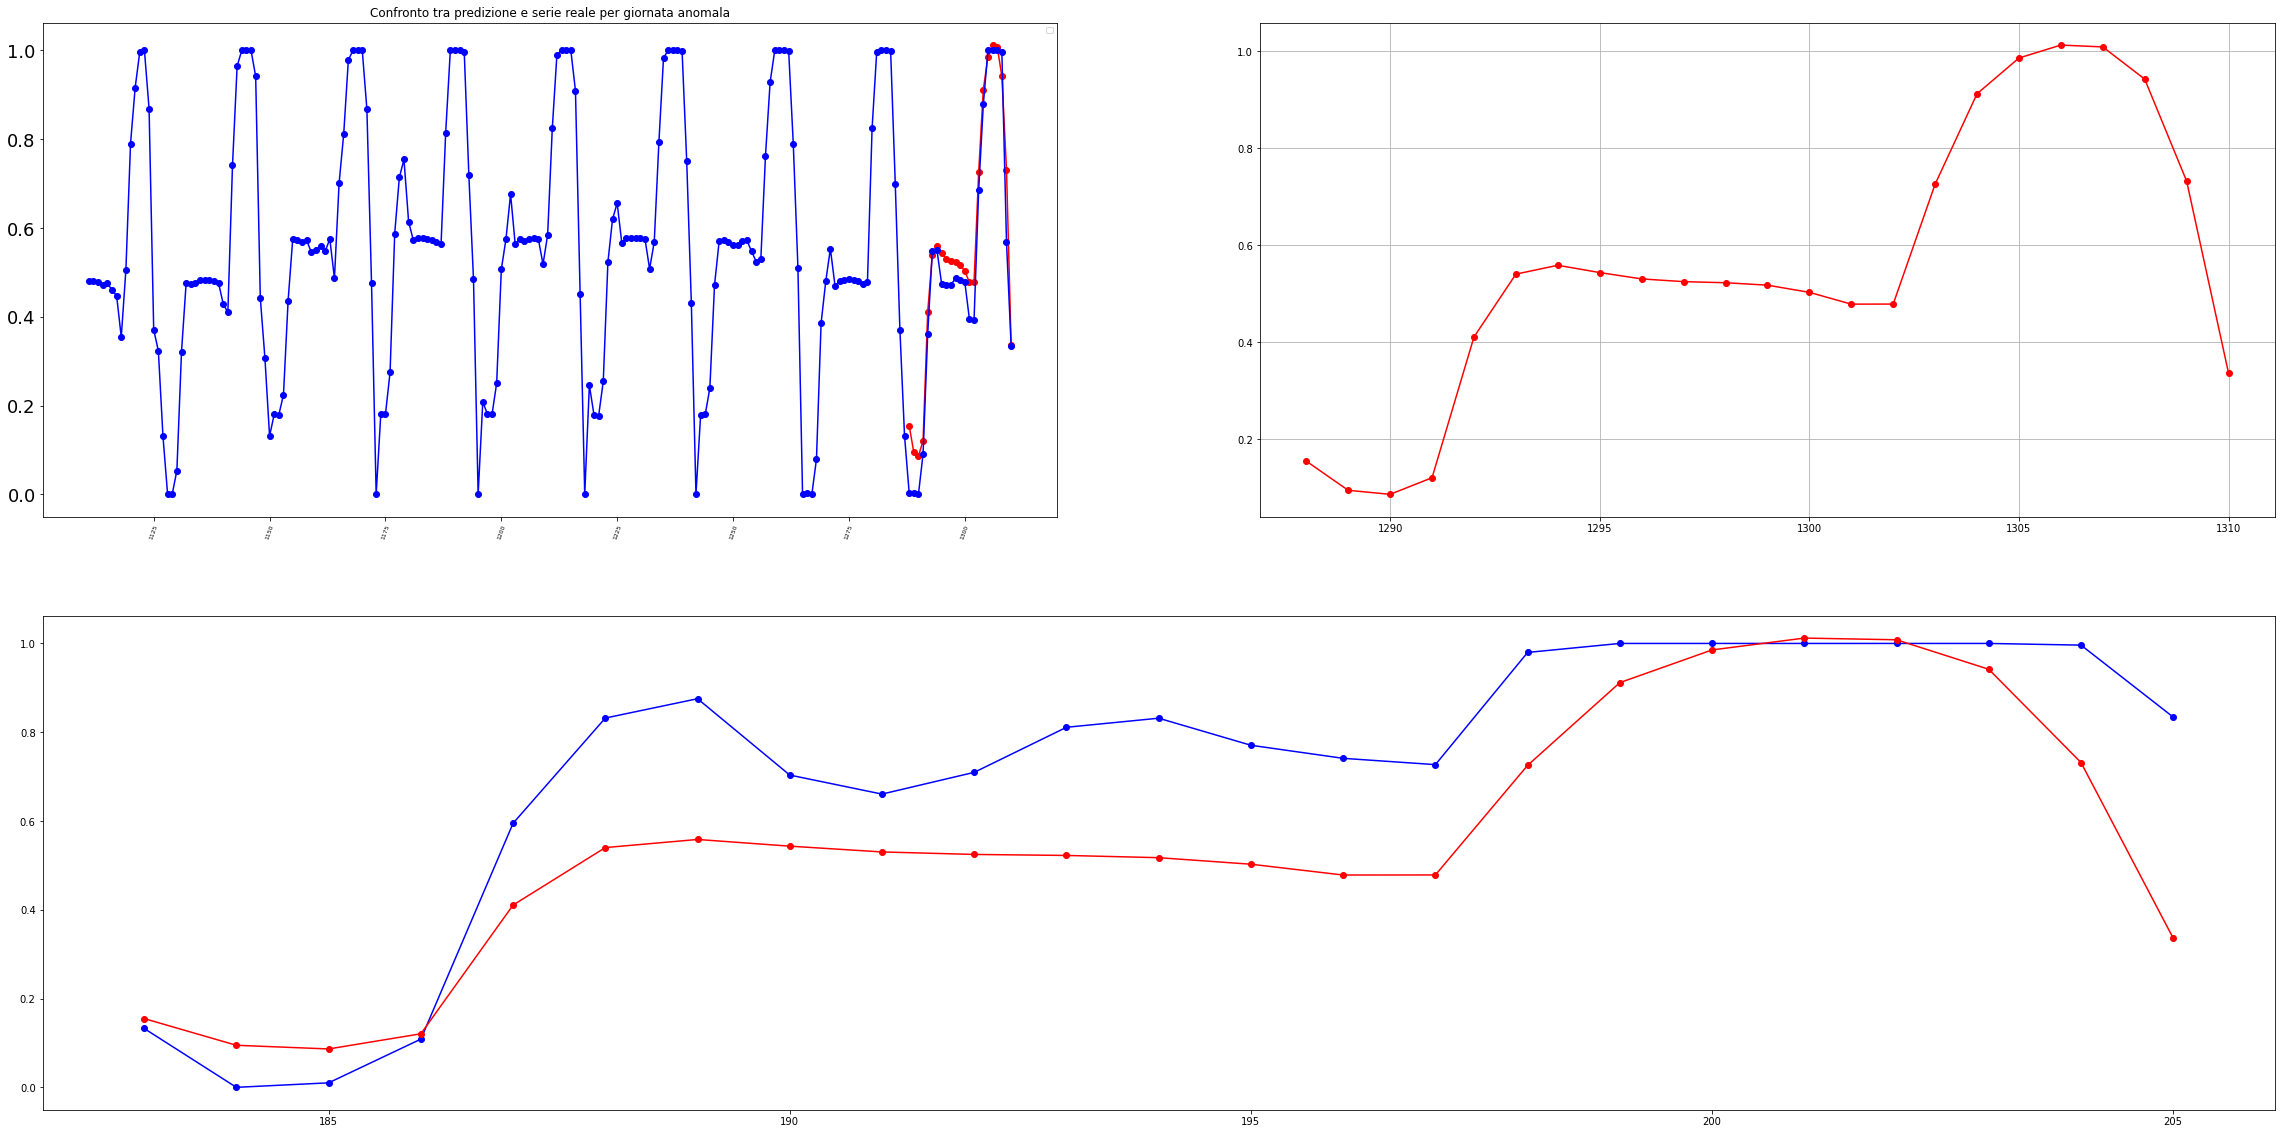

In [ ]:
df = pd.read_csv("finestra.csv")
del df["Unnamed: 0"]

controllati = []
prec = 0

for row in df.itertuples():
  # condizione: giorno anomalo e posso creare una finestra di N giorni
  x = find_count_normal_days(row[0])

  if (row[3] == 1) & (row[4] >= soglia*23): 
    df_target = find_df_target(row[0])
    df_target = pd.DataFrame(df_target)
    df_target.to_csv("target.csv")

    ## tolgo le colonne che non servono al momento
    del df_target["Index"]
    del df_target["_1"]
    del df_target["Anomalous"]
    del df_target["Quanti"]
    del df_target["Finestra"]

    controllati.append(row[1])

    train = df_target
    scaler = MinMaxScaler()
    scaler.fit(train)
    train = scaler.transform(train)

    prediction(train,df,df_target,row,cont)

    prec = row[0]